In [16]:
import numpy as np
import matplotlib.pyplot as plt

from keras import Sequential
from keras.initializers.initializers import RandomNormal
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

In [17]:
class SequencesHandler:
    def __init__(self):
        self.vocabulary = [
            'b',
            'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y',
            'e'
        ]
        self.aa_idx = {aa: i for i, aa in enumerate(self.vocabulary)}


        self.sequences = None
        self.X = None
        self.y = None
        
        self.model = None
        self.history = None

    def aminoacid_to_one_hot(self, aa: str):
        aa_encoding = np.zeros(len(self.vocabulary))
        aa_encoding[self.aa_idx[aa]] = 1
        return aa_encoding

    def sequence_to_one_hot(self, sequence: str):
        result = []
        for aa in sequence:
            aa_encoding = np.zeros(len(self.vocabulary))
            aa_encoding[self.aa_idx[aa]] = 1
            result.append(aa_encoding)
        result = np.array(result)
        return np.reshape(result, (1, result.shape[0], result.shape[1]))

    def load_and_pad_sequences_from_txt(
            self,
            filename: str,
            sequences_amount: int,
            min_length: int,
            max_length: int
    ) -> None:
        sequences = []
        with open(filename, 'r') as file:
            for line in file:
                sequence = line.strip().upper()
                if min_length <= len(sequence) <= max_length:
                    sequences.append(sequence)
                if len(sequences) >= sequences_amount:
                    break
        padding_length = max([len(sequence) for sequence in sequences]) + 1
        self.sequences = []
        for sequence in sequences:
            self.sequences.append('b' + sequence + 'e' * (padding_length - len(sequence)))

    def deduce_patterns(self):
        self.X = []
        self.y = []
        for sequence in self.sequences:
            self.X.append([self.aminoacid_to_one_hot(aa) for aa in sequence[:-1]])
            self.y.append([self.aminoacid_to_one_hot(aa) for aa in sequence[1:]])
        self.X = np.reshape(self.X, (len(self.X), len(self.sequences[0]) - 1, len(self.vocabulary)))
        self.y = np.reshape(self.y, (len(self.y), len(self.sequences[0]) - 1, len(self.vocabulary)))
    
    def sample_next_aa(self, logits, temp=1.0):
        streched = np.log(logits) / temp
        stretched_logits = np.exp(streched) / np.sum(np.exp(streched))
        return np.random.choice(len(streched), p=stretched_logits)
    
    def initialize_and_fit_model(self):
        weight_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=42)
        optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
        
        self.model = Sequential()
        self.model.add(LSTM(
            units=64,
            input_shape=(None, len(sequences_handler.vocabulary)),
            return_sequences=True,
            kernel_initializer=weight_initializer,
            kernel_regularizer=None,
            dropout=0.1
        ))
        self.model.add(LSTM(
            units=64,
            input_shape=(None, len(sequences_handler.vocabulary)),
            return_sequences=True,
            kernel_initializer=weight_initializer,
            kernel_regularizer=None,
            dropout=0.2
        ))
        self.model.add(Dense(
            len(sequences_handler.vocabulary),
            activation='softmax',
            kernel_regularizer=None,
            kernel_initializer=weight_initializer
        ))
        self.model.compile(loss='categorical_crossentropy', optimizer=optimizer)
        self.history = self.model.fit(
            sequences_handler.X,
            sequences_handler.y,
            epochs=100,
            batch_size=64,
            validation_split=0.2,
            shuffle=False
        )

    def show_loss_plot(self):
        plt.plot(self.history.history['loss'])
        plt.plot(self.history.history['val_loss'])
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['training set', 'validation set'], loc='upper right')
        plt.show()

    def sample(self, num=100, minlen=10, maxlen=50, temp=2):
        sampled = []
        ignored_sequences_number = 0
        for i in range(num):
            longest = maxlen
            start_aa = 'b'
            sequence = start_aa
            
            while sequence[-1] != 'e' and len(sequence) <= longest:
                x = self.sequence_to_one_hot(sequence)
                preds = self.model.predict(x)[0][-1]
                next_aa = self.sample_next_aa(preds, temp=temp)
                sequence += self.vocabulary[next_aa]
            
            sequence = sequence[1:-1]
            if 'b' in sequence or len(sequence) < minlen:
                ignored_sequences_number += 1
                continue
                
            sampled.append(sequence)
        
        print(f'{ignored_sequences_number} sequences were shorter than {minlen}')
        return sampled

Epoch 1/100
2/2 [==============================] - 5s 948ms/step - loss: 3.0730 - val_loss: 2.3213
Epoch 2/100
2/2 [==============================] - 0s 55ms/step - loss: 2.2986 - val_loss: 1.9642
Epoch 3/100
2/2 [==============================] - 0s 55ms/step - loss: 2.0044 - val_loss: 1.9252
Epoch 4/100
2/2 [==============================] - 0s 58ms/step - loss: 1.9744 - val_loss: 1.8814
Epoch 5/100
2/2 [==============================] - 0s 56ms/step - loss: 1.9364 - val_loss: 1.8698
Epoch 6/100
2/2 [==============================] - 0s 54ms/step - loss: 1.9081 - val_loss: 1.7914
Epoch 7/100
2/2 [==============================] - 0s 51ms/step - loss: 1.8433 - val_loss: 1.7328
Epoch 8/100
2/2 [==============================] - 0s 55ms/step - loss: 1.7687 - val_loss: 1.6637
Epoch 9/100
2/2 [==============================] - 0s 54ms/step - loss: 1.6942 - val_loss: 1.5999
Epoch 10/100
2/2 [==============================] - 0s 56ms/step - loss: 1.6597 - val_loss: 1.5740
Epoch 11/100
2/2 [

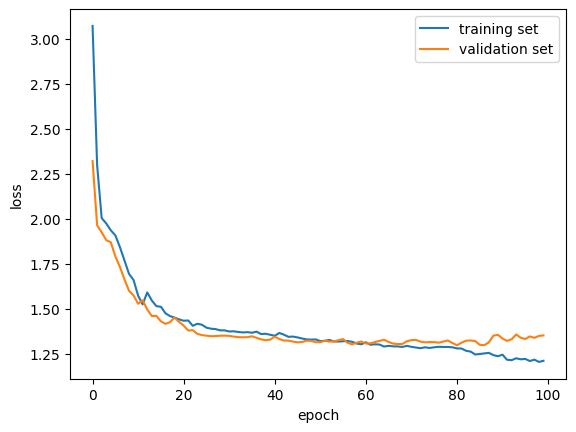

In [18]:
sequences_handler = SequencesHandler()
sequences_handler.load_and_pad_sequences_from_txt(
    filename='best_AMPs.txt',
    sequences_amount=20000,
    min_length=10,
    max_length=50
)
sequences_handler.deduce_patterns()
sequences_handler.initialize_and_fit_model()
sequences_handler.show_loss_plot()

In [19]:
sampled_sequences = sequences_handler.sample(num=10, minlen=10, maxlen=50, temp=2)
for sampled_sequence in sampled_sequences:
    print(sampled_sequence)

1/1 [==============================] - 0s 20ms/step
1 sequences were shorter than 10
MSILFFFSWASQGPQGAQ
MPSHGWGVLLMAVQLVIPGDAWVQAQ
KIRQTAWMTMVLALMKCAGARCGCAP
MRFNVGPAGAVVMTLAKG
KTEQKTRKSVGLSLALILIPTCGCVCPSA
MWQAVLTLSIVLNAVCSA
MWYEIPWTARGF
TTWWAKALPQLANPSVLCNFA
TKKEGNSLVRDIYTAG
